In [1]:
import os
import sys 
import nltk
from nltk import word_tokenize,pos_tag
import nltk.corpus

import string
import re , math
import enchant
import editdistance 
from collections import Counter
from PyDictionary import PyDictionary 




In [2]:
#slang dict creation
f = open('/home/hp/major_project/codes/slang.txt', 'r')
slang_dict = {}
for line in f:
    line = line.strip()
    parts = [p.strip() for p in line.split("=")]
    slang_dict[parts[0].lower()] = (parts[1].lower())
f.close()
#print slang_dict

#creation of abusive words list
file1 = open('/home/hp/major_project/codes/abusive.txt')
abusive = list()
line = file1.readline()
while line:
    word = line.rstrip()
    abusive.append(word)
    line=file1.readline()
file1.close()

#creation of less offensive dict
file1 = open('/home/hp/major_project/codes/less_offensive_new.txt')
less_offensive = list()
line = file1.readline()
while line:
    word = line.rstrip()
    less_offensive.append(word)
    line=file1.readline()
file1.close()

#stop list
stop_list = nltk.corpus.stopwords.words('english')
stop_list.extend(string.punctuation)
stop_list.append('atuser')
stop_list.append('url')
stop_list.append('rt')




In [3]:
os.curdir
if 'SPARK_HOME' not in os.environ:
    os.environ['SPARK_HOME']='/home/hp/Downloads/spark-2.0.0-bin-hadoop2.7'
SPARK_HOME=os.environ['SPARK_HOME']

sys.path.insert(0,os.path.join(SPARK_HOME,"python"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","pyspark.zip"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","py4j-0.10.1-src.zip"))

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.ml.classification import NaiveBayes,NaiveBayesModel
from pyspark.ml import Pipeline 
from pyspark.ml.feature import HashingTF,IDF,Tokenizer

conf=SparkConf()
conf.set("spark.executor.memory","1g")
conf.set("spark.cores.max","1")

conf.setAppName("major")

sc = SparkContext('local',conf=conf)



In [4]:

d = enchant.Dict("en_US")
sqlContext = SQLContext(sc)
import re ,string
def preprocess(x):
    l = x.split(',')
    if(len(l)>=4):
        #convert to lower case
        text = str(l[3].decode('utf-8')).lower()
        text=text.replace('"text":', '')
        
        #2)standardising slang words
        
        l1 = text.split(" ")
        if '' in l1:
            l1.remove('')
        for i in range(len(l1)):
            if l1[i] in slang_dict:
                l1[i] = slang_dict[l1[i]]
        text=' '.join(l1)
        
        #covert @user to at_user
        text= re.sub('@[^\s]+','atuser',text)
        
        #covert #data to data
        text = re.sub(r'#([^\s]+)', r'\1', text)
        
        #Remove additional white spaces
        text = re.sub('[\s]+', ' ', text)
        
        text  = text.replace('\\', '')
        #replace url by 'url'
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
        
         #--feature vector--#

        #1)removing punctuation marks
        text =  text.translate(string.maketrans("",""), string.punctuation)
        
         #3) removing repeated chars
        pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
        text = pattern.sub(r"\1\1", text)
        
        #3) removing words containing no
        text=re.sub(r'\w*\d\w*', '', text).strip()
       
                
        #sid=0
        sid = list(str(l[1]))[5:]
        sid = int(''.join(sid))
        
        return Row(tweet=str(text),tid=sid,status=0)
        
    else:
        return Row(tweet="not there",tid=0,status=0)
        

In [5]:
rdd1 = sc.textFile('/home/hp/major_project/dataset/final_dataset.txt')
rdd1.cache()

final = rdd1.map(preprocess)
print type(final)
final.cache()
df = sc.parallelize(final.collect())
df=df.toDF()
df=df.dropDuplicates(["tweet"])
final.take(2)



<class 'pyspark.rdd.PipelinedRDD'>


[Row(status=0, tid=804980705407234048, tweet='rt atuser remember how the clinton campaign was going to draw lots of moderate r voters by casting trump as not a real'),
 Row(status=0, tid=0, tweet='not there')]

In [6]:
final1 = df.rdd
final1 = final1.filter(lambda x:x.tweet!="not there")
final1=final1.filter(lambda x:x.tweet!='')
#final1=final1.filter(lambda x:len(x.split(' ')>1))
final1.cache()
final1.count()
read_rdd = final1 ##read_id for mapping
read_rdd.take(2)

[Row(status=0, tid=804980807836127232, tweet=u'rt atuser tweets like this mean trump was serious when he said he will tough on china china doesnt recognize taiwan as a'),
 Row(status=0, tid=804980975402819588, tweet=u'atuser nsuspicious activitynurl')]

In [7]:
def proc(x):
    sid = x[1]
    tweet = str(x[2])
    status = x[0]
    tweet = tweet.split(" ")
    tweet1 = [x for x in tweet if x not in stop_list ]
    tweet1=" ".join(tweet1)
    
    #spell correction
    skip = True
    suggestion_list = []
    distances = []
    data = []
    words=tweet1.split(" ")
    for k in range(len(words)):
        if ' ' in words:
            words.remove(' ')
    for k in range(len(words)):
        if  words[k]!='':


            if(d.check(words[k])==False):
                suggestion=d.suggest(words[k])
                if len(suggestion)!=0:
                    for i in range(0,len(suggestion)):
                        distance = editdistance.eval(words[k],suggestion[i])
                        distances.append(distance)
                        suggestion_list.append(suggestion[i])
                    index = distances.index(min(distances))
                    words[k]=suggestion_list[index]
        distances = []
        suggestion_list = []
    tweet1=" ".join(words)


    
    
    
    return Row(tid=sid,tweet=str(tweet1),status=status)
final1 = final1.map(proc)
final1.collect()


[Row(status=0, tid=804980807836127232, tweet="tweets like mean trump serious said tough china china doesn't recognize Taiwan"),
 Row(status=0, tid=804980975402819588, tweet='suspicious activity'),
 Row(status=0, tid=804981122132103168, tweet='shutting preventing Muslims entering us way trump figure better'),
 Row(status=0, tid=804981244828205056, tweet='latest news trump right  via'),
 Row(status=0, tid=804981423195176960, tweet='watch mouth move'),
 Row(status=0, tid=804981440744161280, tweet="white house wasn't told  Taiwan call till happened"),
 Row(status=0, tid=804981474508337152, tweet='foldout know hell get info trump got higher  Romney every category stop spreading lies'),
 Row(status=0, tid=804981490874511360, tweet='wonder senate seat would change'),
 Row(status=0, tid=804981848636030980, tweet='France needs Le pen gt gt Europe trembles Brussels crisis Le pen storms shock poll lead rivals'),
 Row(status=0, tid=804981943578324992, tweet='reedit co warns trump subroutine banned

In [8]:
#func to separate out abusive tweets
def process(x):
        for term in abusive:
            if term in x[2].split(" "):
                return x

In [9]:
#create an abusive rdd from process func
abusive_tweets = final1.filter(process)
abusive_tweets.count()
refined_tweets = final1.subtract(abusive_tweets)
refined_tweets.count()



3209

In [10]:
#function to filter out less offensive tweets
def filter_lessoffensive(x):
        for term in less_offensive:
            if term in x[2].split(" "):
                return x
            
            

In [11]:
non_neutral = refined_tweets.filter(filter_lessoffensive)


neutral_tweets = refined_tweets.subtract(non_neutral)
neutral_tweets.cache()
neutral_tweets.count()



#non_neutral to be used for classification rules.

2814

In [12]:
def intersect(list1,list2):
    return list(set(list1) & set(list2))
def subtract(list1,list2):
    return list(set(list1) - set(list2))

second_pronoun = ['you', 'your', 'yours', 'yourself', 'yourselves', 'yours']
stop_list = subtract(stop_list,second_pronoun)



                        

In [13]:
dictionary = PyDictionary()
boy = dictionary.synonym('boy')
boy.append('boy')
boy.append('guy')
girl = dictionary.synonym('girl')
girl.append('girl')

/home/hp/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [14]:
lenght_offensive = len(less_offensive)
def rules1(x):
    tweet = str(x[2])
    sid = x[1]
    status = x[0]
    text = word_tokenize(tweet)
    text1 = list(text)
    tweet = x[2].split()
    
    after_stop_list = subtract(text,stop_list)
    
     ######### Rule-1 ############
        
    pronoun = intersect(second_pronoun,tweet)
    perojective = intersect(less_offensive,tweet)

    #get index of the words to compare
    if pronoun:
        pronoun_index = tweet.index(pronoun[0])
        pero_index = tweet.index(perojective[0])

        #sid = list(str(x[0]))[5:]
        #sid = int((''.join(sid)))

        if pero_index <= pronoun_index+3:
            status = 1
            return Row(status=status,tid=sid,tweet = ' '.join(tweet))
        else:
            status = 0
            return Row(status=status,tid=sid,tweet = ' '.join(tweet))

    ########## Rule-2 ###########
    
#get the word 
    people_inter = intersect(tweet,boy)
    adjective_inter = intersect(tweet,less_offensive)
    
    if people_inter:
    #find index of people 
        people_index = tweet.index(people_inter[0])

        #find index of adjective
        for i in xrange(len(adjective_inter)):
            adjective_index = tweet.index(adjective_inter[i])
            if people_index <= adjective_index+3:
                status = 1
                return Row(status=status,tid=sid,tweet = ' '.join(tweet))
            else:
                status = 0
                return Row(status=status,tid=sid,tweet = ' '.join(tweet))

    ########## Rule-3 ##########
    
    pos = pos_tag(tweet)
    nnp = 0
    for i in xrange(len(pos)):
        if pos[i][1] == 'NNP':
            nnp = pos.index(pos[i])
        else:
            status = 0
            return Row(status=status,tid=sid,tweet = ' '.join(tweet))
    adj = 0
    text2 = list()
    for i in xrange(len(pos)):
        if pos[i][1] == 'JJ':
            adj = pos.index(pos[i])
            if adj == nnp-1:
                for k in xrange(len(less_offensive)):
                    if less_offensive[k] == pos[i][0]:
                        status = 1
                        return Row(status=status,tid=sid,tweet = ' '.join(tweet))
                    else:
                        status = 0
                        return Row(status=status,tid=sid,tweet = ' '.join(tweet))
    
    

In [15]:
final = non_neutral.map(rules1)
again = final
final.collect()

[Row(status=0, tid=804981286863446016, tweet='petition electoral college reject trump popular history'),
 Row(status=0, tid=804982194187960320, tweet='fight senate support Campbell Dec election amp stop trumps agenda please'),
 Row(status=0, tid=804981207817666560, tweet="gt trump talks illiberality freak outnumber sells Taiwan worth responsibleness don't even remember"),
 Row(status=0, tid=804980848365867008, tweet='well well sure certain Mr trump would prove right quit social media career may depend'),
 Row(status=0, tid=804982171161214976, tweet='trump discovering diplomacy full weird contradictions like kindergarten confused ask go'),
 Row(status=0, tid=804981342261968896, tweet="don't see trump pots danger doesn't either"),
 Row(status=0, tid=804988702447534080, tweet='never thought would agree woman anything carrier deal deception'),
 Row(status=0, tid=804981162556932098, tweet="ex doesn't reject trump"),
 Row(status=0, tid=804982564297457664, tweet='Sarah pain trumps carrier dea

In [19]:
######## Bayes ##########

sqlcontext = SQLContext(sc)
finaldataframe = sqlcontext.createDataFrame(final,['label','tid','tweet'])
finaldataframe.select('label','tid','tweet').show()
(training,testing) = finaldataframe.randomSplit([0.6,0.4])
token = Tokenizer(inputCol = 'tweet',outputCol = 'words')


+-----+------------------+--------------------+
|label|               tid|               tweet|
+-----+------------------+--------------------+
|    0|804981286863446016|petition electora...|
|    0|804982194187960320|fight senate supp...|
|    0|804981207817666560|gt trump talks il...|
|    0|804980848365867008|well well sure ce...|
|    0|804982171161214976|trump discovering...|
|    0|804981342261968896|don't see trump p...|
|    0|804988702447534080|never thought wou...|
|    0|804981162556932098|ex doesn't reject...|
|    0|804982564297457664|Sarah pain trumps...|
|    0|804981290554359808|china blames Taiw...|
|    0|804982096208990208|interview David r...|
|    0|804980883040124928|trump told every ...|
|    0|804995537699303424|um thinking makin...|
|    0|804980753775923200|pretty common kno...|
|    0|804980813901144064|trump trying unif...|
|    0|804982698947162113|trump fighting ha...|
|    0|804981620235268096|don't teach unive...|
|    0|804981428496793600|exclusive chat

In [20]:
token.transform(training)
hashing = HashingTF(inputCol=token.getOutputCol(),outputCol = "tempfeatures")
idf = IDF(inputCol = hashing.getOutputCol() , outputCol = "features")
nb = NaiveBayes()
pipeline = Pipeline(stages=[token,hashing,idf,nb])

nbModel = pipeline.fit(training)

prediction = nbModel.transform(finaldataframe)
print prediction
print type(prediction)

prediction.count()
prediction.collect()


<class 'pyspark.ml.pipeline.Pipeline'>
PipelineModel_4192b97f62da3ab59be6
DataFrame[label: bigint, tid: bigint, tweet: string, words: array<string>, tempfeatures: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]
<class 'pyspark.sql.dataframe.DataFrame'>


[Row(label=0, tid=804981286863446016, tweet=u'petition electoral college reject trump popular history', words=[u'petition', u'electoral', u'college', u'reject', u'trump', u'popular', u'history'], tempfeatures=SparseVector(262144, {7612: 1.0, 17371: 1.0, 77931: 1.0, 85755: 1.0, 175861: 1.0, 194868: 1.0, 234721: 1.0}), features=SparseVector(262144, {7612: 0.4876, 17371: 4.3862, 77931: 4.3862, 85755: 3.8754, 175861: 4.0985, 194868: 4.3862, 234721: 4.0985}), rawPrediction=DenseVector([-257.5375, -324.6621]), probability=DenseVector([1.0, 0.0]), prediction=0.0),
 Row(label=0, tid=804982194187960320, tweet=u'fight senate support Campbell Dec election amp stop trumps agenda please', words=[u'fight', u'senate', u'support', u'campbell', u'dec', u'election', u'amp', u'stop', u'trumps', u'agenda', u'please'], tempfeatures=SparseVector(262144, {4054: 1.0, 46332: 1.0, 60268: 1.0, 102123: 1.0, 107741: 1.0, 124634: 1.0, 201383: 1.0, 202268: 1.0, 217316: 1.0, 229323: 1.0, 230921: 1.0}), features=Spars

In [21]:
prediction.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    3|
|    0|       0.0|  389|
|    1|       1.0|    3|
+-----+----------+-----+



In [26]:
sqlcontext.registerDataFrameAsTable(prediction,'table')
dataframe = sqlcontext.table('table')
tp = sqlcontext.sql('select label,prediction from table where label=1 AND prediction = 1.0').count()
tn = sqlcontext.sql('select label,prediction from table where label=1 AND prediction = 0.0').count()
fp = sqlcontext.sql('select label,prediction from table where label=0 AND prediction = 0.0').count()
fn = sqlcontext.sql('select label,prediction from table where label = 0 and prediction = 1.0').count()

precision = float(tp*100/(tp+fp))
recall = tp*100/(tp+fn)
accuracy = (tp+tn)*100/(tp+tn+fp+fn)
print tp
print fp
print fn
print tn
print precision 
print recall
print accuracy

3
389
0
3
7.0
100
15


In [27]:
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models
import gensim


/home/hp/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/gensim-0.13.3-py2.7-linux-x86_64.egg/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [28]:
final_list = []
for x in final.collect():
    final_list.append((x[2]))

print final_list[0]
main_tokens = []
less = []
tokenizer = RegexpTokenizer(r'\w+')
for i in xrange(len(final_list)):
    tokens = tokenizer.tokenize(final_list[i])
    main_tokens.append(tokens)

for j in xrange(len(less_offensive)):
    token = tokenizer.tokenize(less_offensive[j])
    less.append(token)

dictionary1 = corpora.Dictionary(main_tokens)
print(dictionary1)


dictionary2=corpora.Dictionary(less)
print(dictionary2) 


petition electoral college reject trump popular history
Dictionary(1581 unique tokens: [u'suicidal', u'protest', u'aides', u'Powhatan', u'hate']...)
Dictionary(254 unique tokens: [u'malicious', u'poor', u'vindictive', u'vile', u'wound']...)


In [29]:
main_corpus = [dictionary1.doc2bow(text) for text in main_tokens]
print main_corpus

less_corpus = [dictionary2.doc2bow(text) for text in less]
print less_corpus


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)], [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)], [(0, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)], [(0, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1)], [(0, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1)], [(0, 1), (27, 1), (30, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)], [(35, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1)], [(0, 1), (3, 1), (30, 1), (57, 1), (67, 1)], [(17, 2), (59, 1), (62, 1), (65, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1)], [(0, 1), (24, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1)], [(0, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1)], [(0, 1), (88, 1), (89, 1), (90, 1), (91, 

In [30]:
ldamodel = gensim.models.ldamodel.LdaModel(main_corpus, num_topics=2, id2word = dictionary1, passes=50, alpha='auto')
a=ldamodel[less_corpus]

In [32]:
list1 = []
for x in xrange(len(final_list)):
    string = ''.join(final_list[x])
    list1.append(string)
    
status = []
for x in xrange(len(list1)):
    new_vec = dictionary2.doc2bow(list1[x].split())
    c= ldamodel[new_vec]
    print(list1[x])
    print c
    length = len(c)
    if length == 1: 
        status.append(c[0][0])
    elif c[0][1]>c[1][1]:
        status.append(c[0][0])
    else:
        status.append(c[1][0])
print status

petition electoral college reject trump popular history
[(0, 0.04330458186324939), (1, 0.95669541813675074)]
fight senate support Campbell Dec election amp stop trumps agenda please
[(0, 0.043304582086936223), (1, 0.95669541791306378)]
gt trump talks illiberality freak outnumber sells Taiwan worth responsibleness don't even remember
[(0, 0.54106797748372382), (1, 0.45893202251627618)]
well well sure certain Mr trump would prove right quit social media career may depend
[(0, 0.96326920101089875), (1, 0.036730798989101233)]
trump discovering diplomacy full weird contradictions like kindergarten confused ask go
[(0, 0.96326920101037949), (1, 0.036730798989620603)]
don't see trump pots danger doesn't either
[(0, 0.54106797748372382), (1, 0.45893202251627618)]
never thought would agree woman anything carrier deal deception
[(0, 0.96326920101168456), (1, 0.036730798988315452)]
ex doesn't reject trump
[(0, 0.043304581887375633), (1, 0.95669541811262437)]
Sarah pain trumps carrier deal crony c

In [33]:
non_tweets = []
neu_tweets = []
neutral_status = []
non_status = []
def lda_fun():
    
    neutral_count = 0
    non_count = 0
    for x in xrange(len(status)):
        if status[x] == 1:
            neu_tweets.append(list1[x])
            neutral_count +=1
            neutral_status.append(status[x])
        elif status[x] == 0:
            non_tweets.append(list1[x])
            non_count +=1
            non_status.append(status[x])
   
    return [[neu_tweets,neutral_status],[non_tweets,non_status]]
ll = lda_fun()
neutral_rdd = sc.parallelize(ll[0][0])
non_rdd = sc.parallelize(ll[1][0])




In [34]:
def create_neutral_row(x):
    st = 1
    return Row(tweet = x,status = st)

def create_non_row(x):
    st = 0
    return Row(tweet = x,status = st)

neutral_row = neutral_rdd.map(create_neutral_row)
non_row = non_rdd.map(create_non_row)
final_rdd = non_row.union(neutral_row)


In [35]:
sqlcontext = SQLContext(sc)
lda_finaldataframe = sqlcontext.createDataFrame(final_rdd,['label','tweet'])
lda_finaldataframe.select('label','tweet').show()
(lda_training,lda_testing) = lda_finaldataframe.randomSplit([0.6,0.4])
lda_token = Tokenizer(inputCol = 'tweet',outputCol = 'words')


+-----+--------------------+
|label|               tweet|
+-----+--------------------+
|    0|gt trump talks il...|
|    0|well well sure ce...|
|    0|trump discovering...|
|    0|don't see trump p...|
|    0|never thought wou...|
|    0|china blames Taiw...|
|    0|interview David r...|
|    0|um thinking makin...|
|    0|trump trying unif...|
|    0|don't teach unive...|
|    0|exclusive chat lo...|
|    0|Anderson cooper h...|
|    0|idea governed som...|
|    0|breakfast sorry t...|
|    0|trump would never...|
|    0|mean white suprem...|
|    0|Donald trump abso...|
|    0|done Glasgow trum...|
|    0|um confused trump...|
|    0|nothing minority ...|
+-----+--------------------+
only showing top 20 rows



In [36]:
lda_token.transform(lda_training)
lda_hashing = HashingTF(inputCol=lda_token.getOutputCol(),outputCol = "tempfeatures")
lda_idf = IDF(inputCol = lda_hashing.getOutputCol() , outputCol = "features")
lda_nb = NaiveBayes()
lda_pipeline = Pipeline(stages=[lda_token,lda_hashing,lda_idf,lda_nb])
lda_nbModel = lda_pipeline.fit(lda_training)
lda_prediction = lda_nbModel.transform(lda_finaldataframe)
lda_prediction.collect()


[Row(label=0, tweet=u"gt trump talks illiberality freak outnumber sells Taiwan worth responsibleness don't even remember", words=[u'gt', u'trump', u'talks', u'illiberality', u'freak', u'outnumber', u'sells', u'taiwan', u'worth', u'responsibleness', u"don't", u'even', u'remember'], tempfeatures=SparseVector(262144, {7612: 1.0, 102787: 1.0, 113418: 1.0, 174881: 1.0, 174966: 1.0, 176454: 1.0, 193904: 1.0, 196997: 1.0, 207380: 1.0, 218158: 1.0, 224609: 1.0, 228453: 1.0, 259506: 1.0}), features=SparseVector(262144, {7612: 0.4802, 102787: 4.7707, 113418: 2.0965, 174881: 2.245, 174966: 4.7707, 176454: 4.7707, 193904: 4.7707, 196997: 4.3652, 207380: 4.7707, 218158: 4.7707, 224609: 4.7707, 228453: 4.3652, 259506: 4.7707}), rawPrediction=DenseVector([-547.2335, -620.503]), probability=DenseVector([1.0, 0.0]), prediction=0.0),
 Row(label=0, tweet=u'well well sure certain Mr trump would prove right quit social media career may depend', words=[u'well', u'well', u'sure', u'certain', u'mr', u'trump',

In [37]:
lda_prediction.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   23|
|    0|       1.0|   19|
|    0|       0.0|  179|
|    1|       1.0|  174|
+-----+----------+-----+



In [38]:
sqlcontext.registerDataFrameAsTable(lda_prediction,'lda_table')
lda_dataframe = sqlcontext.table('lda_table')
lda_tp = sqlcontext.sql('select label,prediction from lda_table where label=1 AND prediction = 1.0').count()
lda_tn = sqlcontext.sql('select label,prediction from lda_table where label=1 AND prediction = 0.0').count()
lda_fp = sqlcontext.sql('select label,prediction from lda_table where label=0 AND prediction = 0.0').count()
lda_fn = sqlcontext.sql('select label,prediction from lda_table where label=0 and prediction = 1.0').count()

lda_precision = lda_tp*100/(lda_tp+lda_fp)
lda_recall = lda_tp*100/(lda_tp+lda_fn)
lda_accuracy = (lda_tp + lda_tn)*100/(lda_tp + lda_tn + lda_fp + lda_fn)

print lda_precision 
print lda_recall
print lda_accuracy

49
90
49


In [39]:
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt

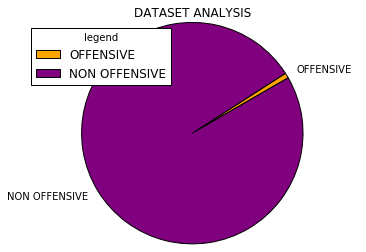

In [44]:
### graph for rule based
sizes=[0.76,99.24] #sum of all the elements should be 100
colors=['orange','purple']
labels=['OFFENSIVE','NON OFFENSIVE']
plt.pie(sizes,colors=colors,startangle=30,labels=labels)
plt.axis('equal') #to make a proper circle
plt.title('DATASET ANALYSIS')
plt.legend(title='legend',loc='best')
plt.show()

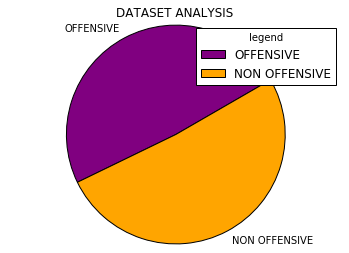

In [45]:
### graph for hybrid model
sizes=[48.86,51.14] #sum of all the elements should be 100
colors=['purple','orange']
labels=['OFFENSIVE','NON OFFENSIVE']
plt.pie(sizes,colors=colors,startangle=30,labels=labels)
plt.axis('equal') #to make a proper circle
plt.title('DATASET ANALYSIS')
plt.legend(title='legend',loc='best')
plt.show()

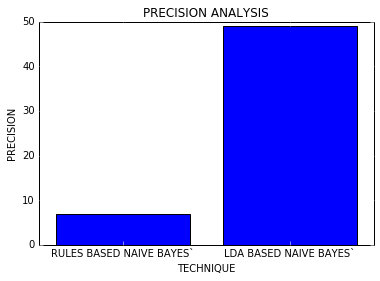

In [40]:
import numpy as np
pos=np.arange(2)+1
years=["RULES BASED NAIVE BAYES`", "LDA BASED NAIVE BAYES`"]
plt.bar(pos,(precision,lda_precision),align='center',color='blue')
plt.xlabel('TECHNIQUE')
plt.ylabel('PRECISION')
plt.title('PRECISION ANALYSIS')
plt.tick_params(axis='x',color='white')
plt.tick_params(axis='y',color='white')
plt.xticks(pos,years)
 
plt.show()

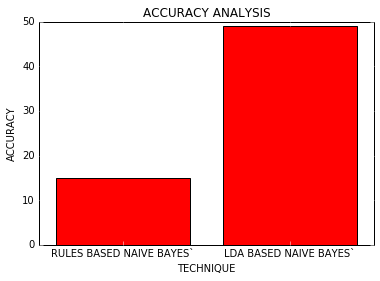

In [41]:
import numpy as np
pos=np.arange(2)+1
years=["RULES BASED NAIVE BAYES`", "LDA BASED NAIVE BAYES`"]
plt.bar(pos,(accuracy,lda_accuracy),align='center',color='red')
plt.xlabel('TECHNIQUE')
plt.ylabel('ACCURACY')
plt.title('ACCURACY ANALYSIS')
plt.tick_params(axis='x',color='white')
plt.tick_params(axis='y',color='white')
plt.xticks(pos,years)
 
plt.show()

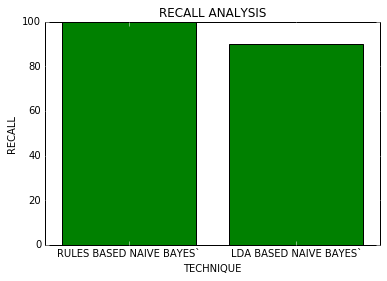

In [42]:
pos=np.arange(2)+1
years=["RULES BASED NAIVE BAYES`", "LDA BASED NAIVE BAYES`"]
plt.bar(pos,(recall,lda_recall),align='center',color='green')
plt.xlabel('TECHNIQUE')
plt.ylabel('RECALL')
plt.title('RECALL ANALYSIS')
plt.tick_params(axis='x',color='white')
plt.tick_params(axis='y',color='white')
plt.xticks(pos,years)
plt.show()
